In [120]:
import pymonntorch

In [121]:
pymonntorch.__version__

'0.1.4'

In [122]:
net = pymonntorch.Network()

In [123]:
net.initialize()

Network['Network_1', 'Network'](Neurons: tensor(0.)|0 groups, Synapses: tensor(0.)|0 groups){}


In [124]:
net.simulate_iterations(1000)

1000xBatch: 1/1 (100%) 8.012ms


8.012056350708008

In [125]:
from pymonntorch import *
import torch
from matplotlib import pyplot as plt
import random

# Current

In [126]:
class SetCurrent(Behavior):
	def initialize(self, ng):
		self.offset = self.parameter("value")
		ng.I = ng.vector(mode = self.offset)

	def forward(self, ng):
		ng.I.fill_(self.offset)

class StepFunction(Behavior):
	def initialize(self, ng):
		self.value = self.parameter("value")
		self.t0 = self.parameter("t0")

	def forward(self, ng):
		if ng.network.iteration * ng.network.dt >= self.t0:
			ng.I += ng.vector(mode=self.value) * ng.network.dt

dt

In [127]:
class TimeResolution(Behavior):
	def initialize(self, network):
		network.dt = self.parameter("dt", 1.0)

Synapse

In [128]:
class SynFun(Behavior):
	def initialize(self, sg):
		sg.W = sg.matrix(mode="normal(0.5, 0.3)")
		sg.I = sg.dst.vector()

	def forward(self, sg):
		sg.I = torch.sum(sg.W[sg.src.spike], axis=0)

class InpSyn(Behavior):
	def forward(self, ng):
		for syn in ng.afferent_synapses["All"]:
			ng.I += syn.I

LIF model

In [129]:
class LIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset


	def forward(self, ng):
		
		# firing
		ng.spike = ng.v >= self.threshold

		#reset
		ng.v[ng.spike] = self.u_reset
		
		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I
		ng.v += (leakage + currents) / self.tau * ng.network.dt

LIF main

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:SetCurrent(value=50,)3:StepFunction(value=40,t0=20,)5:LIF(tau=20,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
100xBatch: 1/1 (100%) 36.707ms


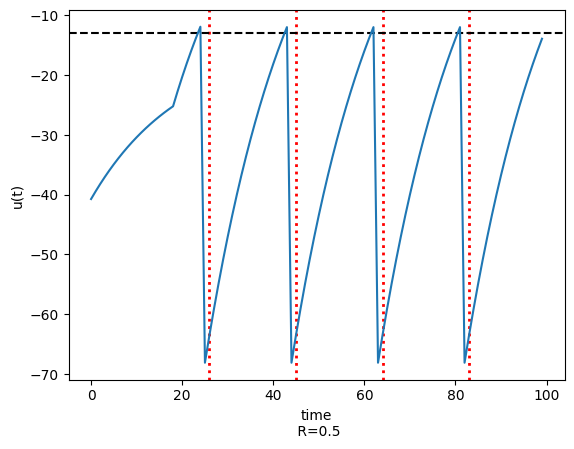

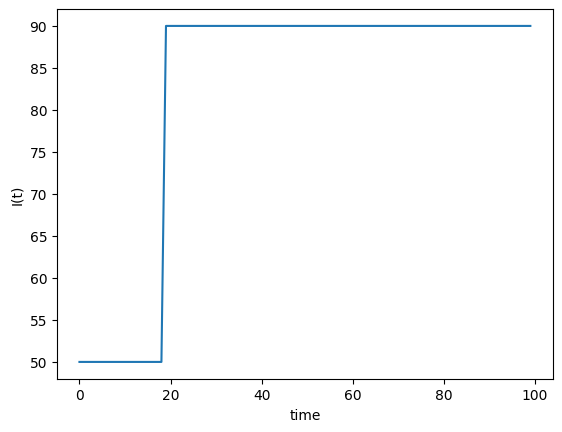

In [130]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    1,
    net=net1,
    behavior={
        2: SetCurrent(value=50),
        3: StepFunction(value=40, t0=20),
        # 4: InpSyn(),
        5: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),
    },
    tag="NG1",
)

# SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
#                  3: SynFun(),
#             })

net1.initialize()

net1.simulate_iterations(100)

# print(net1["ng1_rec", 0]["v", 0])
# print(net1["ng1_evrec", 0]["spike", 0])

for i, t in enumerate(net1['spike', 0]) :
    plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)

plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net1["v", 0][:,:1])
plt.xlabel("time\n R=0.5")
plt.ylabel("u(t)")
plt.show()

plt.plot(net1["I", 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()

# plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
# plt.show()

Sin function

In [131]:
class SinFunc(Behavior) :
    def initialize(self, ng):
        self.value = self.parameter("value", 10)

    def forward(self, ng):
        ng.I = ng.vector(mode = self.value) * np.sin(ng.network.iteration/180 * np.pi)**2 * ng.network.dt

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){2:SinFunc(value=40,)3:LIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,R=1.5,v_init=normal(-40, 10),)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
1000xBatch: 1/1 (100%) 301.962ms


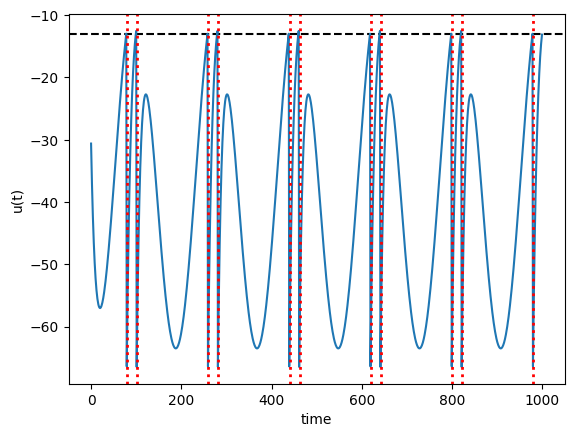

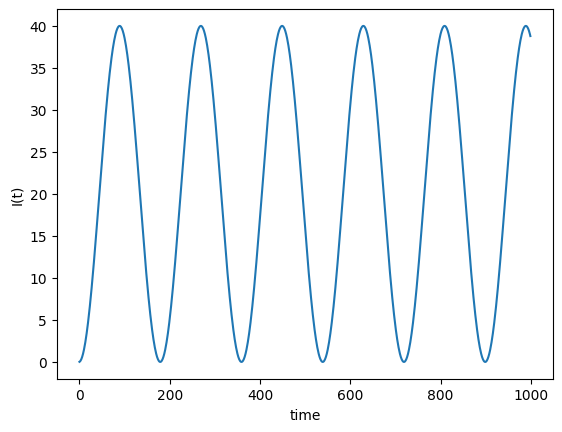

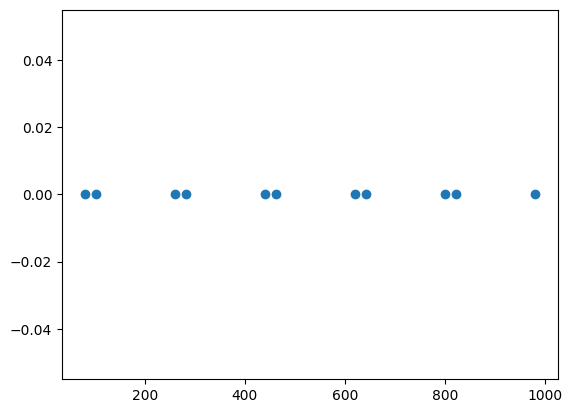

In [132]:
net2 = Network(behavior={
    1 : TimeResolution()
})

ng2 = NeuronGroup(net = net2, size = 1, behavior={
    2 : SinFunc(value = 40),
    3 : LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1.5,
            v_init="normal(-40, 10)",
        ),
    9 : Recorder(['v', 'I']),
    10 : EventRecorder(['spike'])
})

# SynapseGroup(net=net2, src=ng2, dst=ng2, behavior={
#                  3: SynFun(),
#             })

net2.initialize()

net2.simulate_iterations(1000)

# for i, t in enumerate(net1['spike', 0]) :
#     plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)

plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net2['v', 0][:,:1])
for i, t in enumerate(net2['spike', 0]) :
    plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)
plt.xlabel("time")
plt.ylabel("u(t)")
plt.show()

plt.plot(net2['I', 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()


plt.scatter(net2["spike", 0][:,0], net2["spike", 0][:,1])
plt.show()

Exponential LIF model

In [133]:
class ELIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")
		self.Delta_t = self.parameter("Delta_t", 2)
		#self.theta_rh = self.parameter("theta_rh")

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset

		ng.cnt = ng.vector("zeros")


	def forward(self, ng):
		# firing
		ng.spike = ng.v >= self.threshold

		#reset
		ng.v[ng.spike] = self.u_reset

		#cnt++
		ng.cnt[ng.spike]+=1
		
		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I
		expon = (self.Delta_t * torch.exp((ng.v - self.threshold)/self.Delta_t))
		ng.v += (leakage + currents + expon) / self.tau * ng.network.dt

ELIF main

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG3', 'NeuronGroup', 'ng'](1){2:SetCurrent(value=30,)3:StepFunction(value=20,t0=20,)5:ELIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,R=1,Delta_t=20,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng3_rec, ng3_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng3_evrec,arg_0=spike,)}
100xBatch: 1/1 (100%) 94.279ms


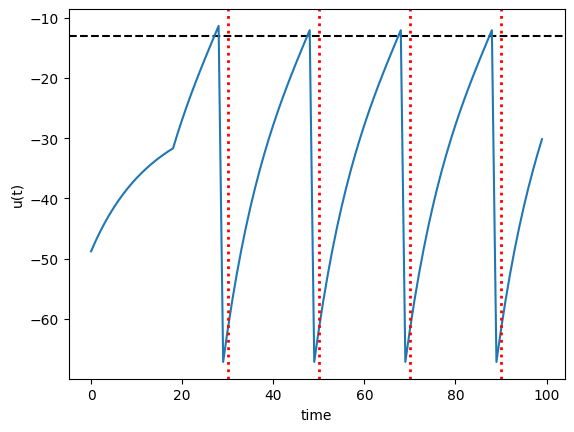

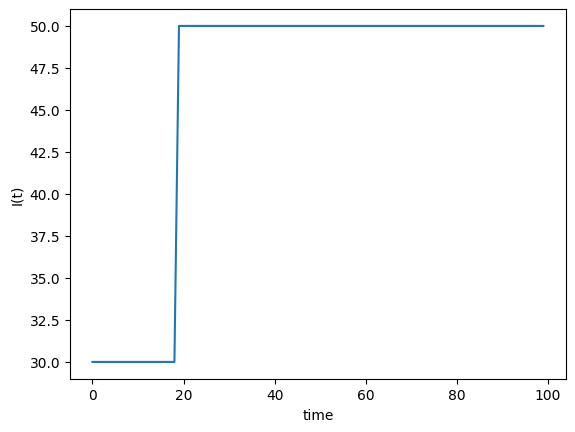

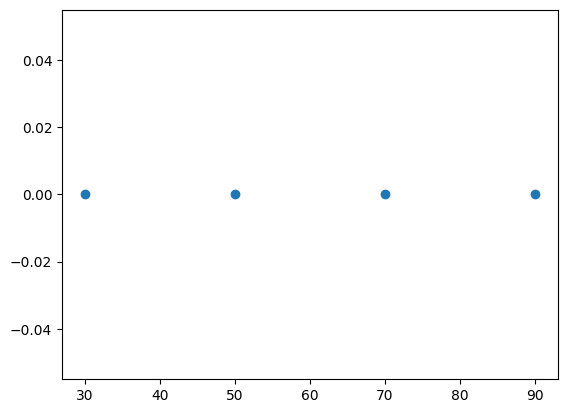

In [134]:
net3 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng3 = NeuronGroup(
    1,
    net=net3,
    behavior={
        2: SetCurrent(value=30),
        3: StepFunction(value=20, t0=20),
        # 4: InpSyn(),
        5: ELIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            Delta_t=20,
            #theta_rh=-25,
            
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I"], tag="ng3_rec, ng3_recorder"),
        10: EventRecorder("spike", tag="ng3_evrec"),
    },
    tag="NG3",
)

# SynapseGroup(net=net3, src=ng3, dst=ng3, behavior={
#                  3: SynFun(),
#             })

net3.initialize()

net3.simulate_iterations(100)

# print(net3["ng3_rec", 0]["v", 0])
# print(net3["ng3_evrec", 0]["spike", 0])

plt.axhline(-13, color = 'black', linestyle = '--')

# def get_sub(x):
#     normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
#     sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
#     res = x.maketrans(''.join(normal), ''.join(sub_s))
#     return x.translate(res)

plt.plot(net3["v", 0][:,:1])
for i, t in enumerate(net3['spike', 0]) :
    plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)
plt.xlabel("time")
# plt.xlabel("time\n""\u0394{}=0.05".format(get_sub(" T")))
plt.ylabel("u(t)")
plt.show()

plt.plot(net3["I", 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()

plt.scatter(net3["spike", 0][:,0], net3["spike", 0][:,1])
plt.show()

ELIF Sin

In [135]:
class SinFunc(Behavior) :
    def initialize(self, ng):
        self.value = self.parameter("value", 10)

    def forward(self, ng):
        ng.I = ng.vector(mode = self.value) * np.sin(ng.network.iteration/180 * np.pi)**2 * ng.network.dt

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){2:SinFunc(value=40,)5:ELIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,R=1,Delta_t=20,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng10_rec, ng10_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng10_evrec,arg_0=spike,)}
1000xBatch: 1/1 (100%) 339.278ms


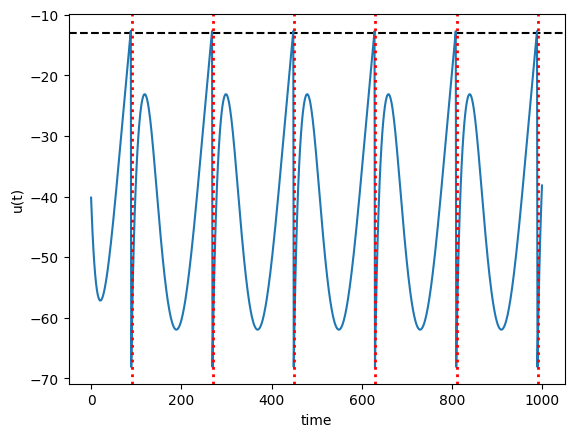

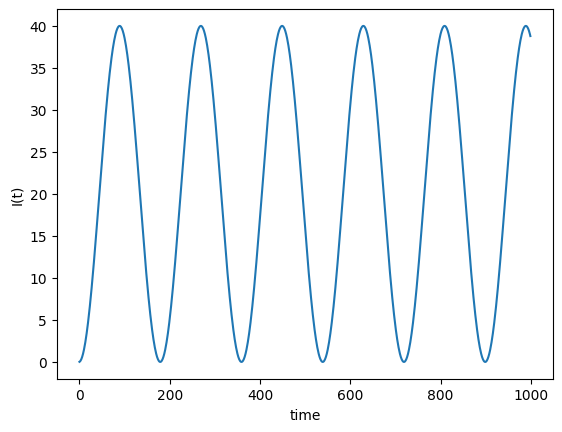

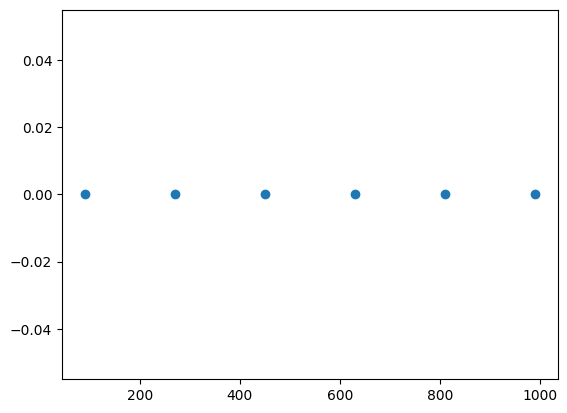

In [136]:
net10 = Network(behavior={
    1 : TimeResolution()
})

ng10 = NeuronGroup(net = net10, size = 1, behavior={
    2 : SinFunc(value = 40),
    5: ELIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            Delta_t=20,
            #theta_rh=-25,
            
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I"], tag="ng10_rec, ng10_recorder"),
        10: EventRecorder("spike", tag="ng10_evrec"),
})

# SynapseGroup(net=net10, src=ng10, dst=ng10, behavior={
#                  3: SynFun(),
#             })

net10.initialize()

net10.simulate_iterations(1000)

# for i, t in enumerate(net1['spike', 0]) :
#     plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)

plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net10['v', 0][:,:1])
for i, t in enumerate(net10['spike', 0]) :
    plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)
plt.xlabel("time")
plt.ylabel("u(t)")
plt.show()

plt.plot(net10['I', 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()


plt.scatter(net10["spike", 0][:,0], net10["spike", 0][:,1])
plt.show()

Adaptive Exponential LIF model

In [137]:
class AELIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")

		self.Delta_t = self.parameter("Delta_t", 2)

		self.a=self.parameter("a", 5)
		self.b=self.parameter("b", 5)
		ng.w = ng.vector("zeros")
		self.tau_w = self.parameter("tau_w", 2)

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset
		


	def forward(self, ng):
		# firing
		ng.spike = ng.v >= self.threshold

		#reset
		ng.v[ng.spike] = self.u_reset

		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I
		expon = (self.Delta_t * torch.exp((ng.v - self.threshold)/self.Delta_t))
		adpt = (self.R * ng.w)
		ng.v += ((leakage + currents) + expon - adpt) / self.tau * ng.network.dt
		ng.w += (self.a*(ng.v - self.u_rest) - ng.w + self.b * self.tau_w * ng.spike) / self.tau_w * ng.network.dt

### AELIF main ###

Adding Noise ###

In [138]:
class NoiseFun(Behavior) :
    def initialize(self, ng):
        self.value = self.parameter("value", 10)

    def forward(self, ng):
        ng.I = (ng.vector(mode = self.value) * ng.network.dt + ((random.random() * self.value - self.value/2)))
        

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG4', 'NeuronGroup', 'ng'](1){2:NoiseFun(value=100,)5:AELIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,Delta_t=30,R=1,tau_w=40,a=2,b=0.7,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng4_rec, ng4_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng4_evrec,arg_0=spike,)}
300xBatch: 1/1 (100%) 108.455ms


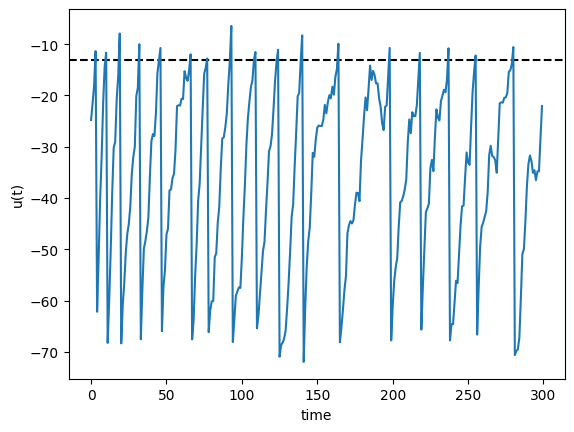

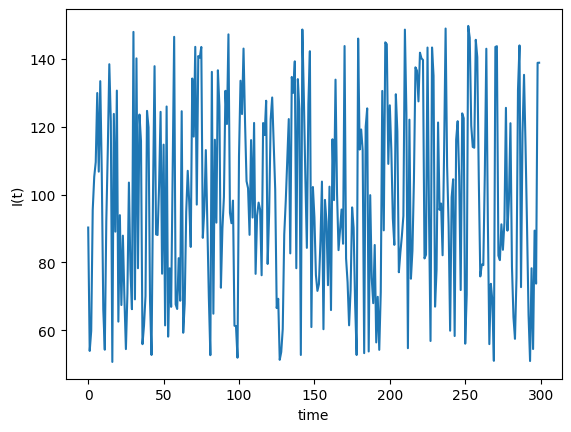

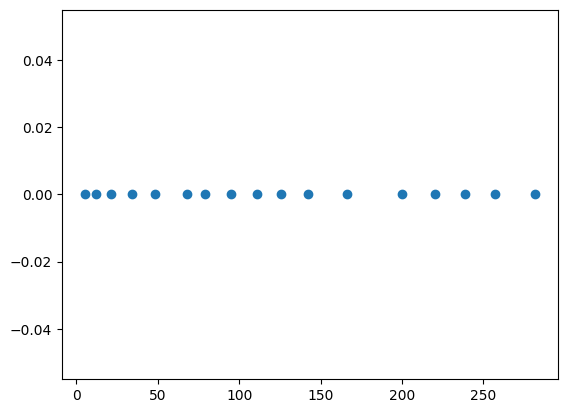

In [139]:
net4 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng4 = NeuronGroup(
    1,
    net=net4,
    behavior={
        2 : NoiseFun(value = 100),
        # 4: InpSyn(),
        5: AELIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            Delta_t = 30,
            R=1,
            tau_w=40,
            a=2,
            b=.7,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I"], tag="ng4_rec, ng4_recorder"),
        10: EventRecorder("spike", tag="ng4_evrec"),
    },
    tag="NG4",
)

# SynapseGroup(net=net4, src=ng4, dst=ng4, behavior={
#                  3: SynFun(),
#             })

net4.initialize()

net4.simulate_iterations(300)

# print(net4["ng4_rec", 0]["v", 0])
# print(net4["ng4_evrec", 0]["spike", 0])

plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net4["v", 0][:,:1])
# for i, t in enumerate(net10['spike', 0]) :
#     plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)
plt.xlabel("time")
plt.ylabel("u(t)")
plt.show()

plt.plot(net4["I", 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()

plt.scatter(net4["spike", 0][:,0], net4["spike", 0][:,1])
plt.show()

LIF with noise

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){2:NoiseFun(value=50,)3:LIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,R=1.5,v_init=normal(-40, 10),)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
100xBatch: 1/1 (100%) 28.337ms


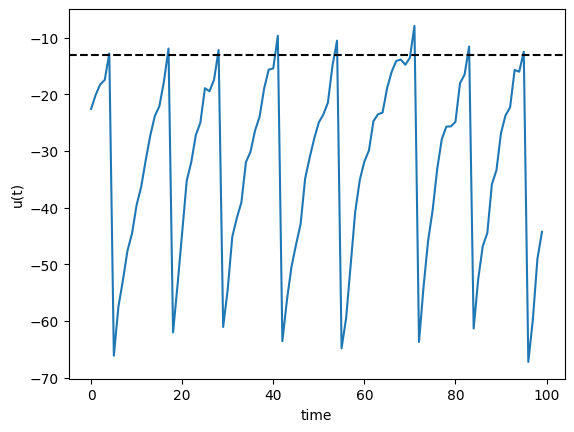

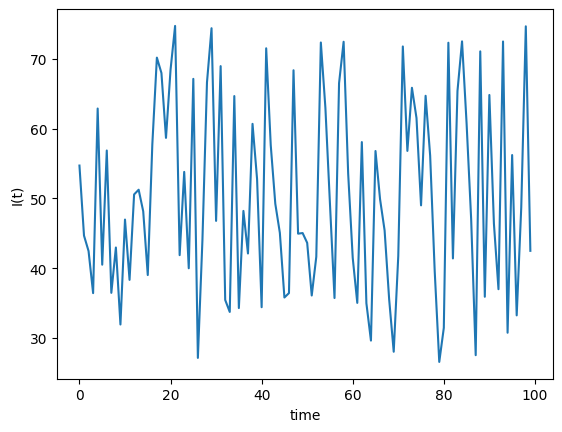

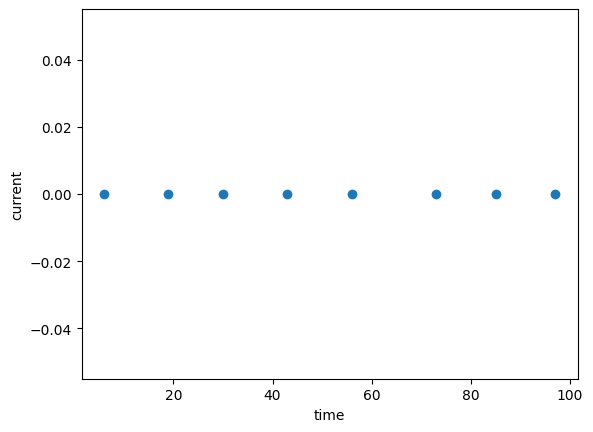

In [140]:
net5 = Network(behavior={
    1 : TimeResolution()
})

ng5 = NeuronGroup(net = net5, size = 1, behavior={
    2 : NoiseFun(value = 50),
    3 : LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1.5,
            v_init="normal(-40, 10)",
        ),
    9 : Recorder(['v', 'I']),
    10 : EventRecorder(['spike'])
})

# SynapseGroup(net=net5, src=ng5, dst=ng5, behavior={
#                 3 : NoiseFun(),
#             })

net5.initialize()

net5.simulate_iterations(100)

#plt.axhline(-13, color = 'black', linestyle = '--')


plt.plot(net5['v', 0][:,:1])
plt.axhline(-13, color = 'black', linestyle = '--')
# for i, t in enumerate(net1['spike', 0]) :
#     plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)
plt.xlabel("time")
plt.ylabel("u(t)")
plt.show()

plt.plot(net5['I', 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()

plt.scatter(net5["spike", 0][:,0], net5["spike", 0][:,1])
plt.xlabel("time")
plt.ylabel("current")
plt.show()

ELIF with noise

In [141]:
class NoiseFun(Behavior) :
    def initialize(self, ng):
        self.value = self.parameter("value", 10)

    def forward(self, ng):
        ng.I = (ng.vector(mode = self.value) * ng.network.dt + ((random.random() * self.value - self.value/2)))
        

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){2:NoiseFun(value=50,)5:ELIF(tau=30,u_rest=-65,u_reset=-73,threshold=-13,R=1,Delta_t=60,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng10_rec, ng10_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng10_evrec,arg_0=spike,)}
100xBatch: 1/1 (100%) 31.136ms


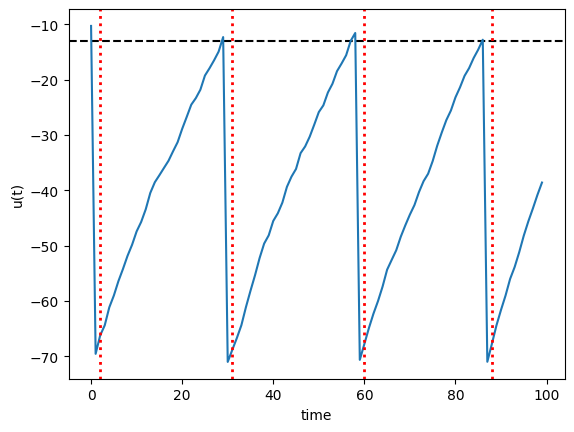

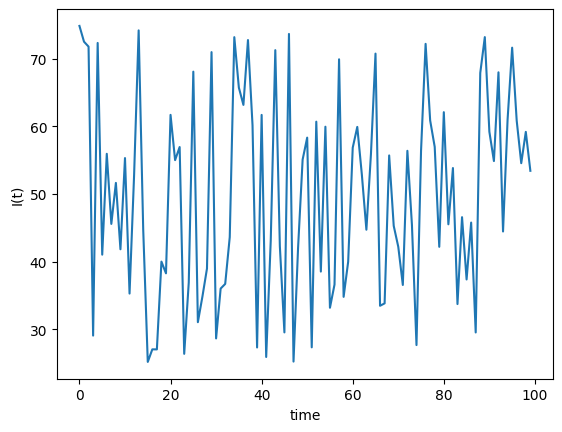

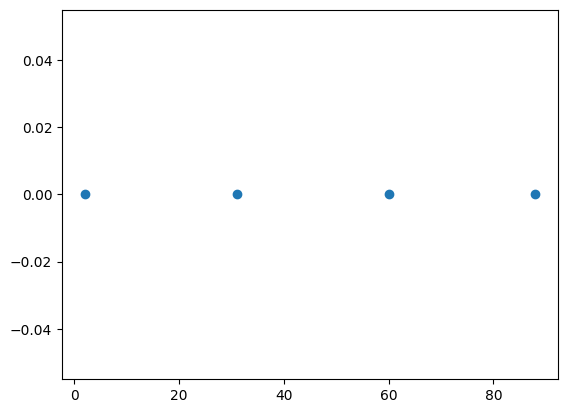

In [142]:
net10 = Network(behavior={
    1 : TimeResolution()
})

ng10 = NeuronGroup(net = net10, size = 1, behavior={
    2 : NoiseFun(value = 50),
    5: ELIF(
            tau=30,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            Delta_t=60,
            #theta_rh=-25,
            
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I"], tag="ng10_rec, ng10_recorder"),
        10: EventRecorder("spike", tag="ng10_evrec"),
})

# SynapseGroup(net=net10, src=ng10, dst=ng10, behavior={
#                  3: SynFun(),
#             })

net10.initialize()

net10.simulate_iterations(100)

# for i, t in enumerate(net1['spike', 0]) :
#     plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)

plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net10['v', 0][:,:1])
for i, t in enumerate(net10['spike', 0]) :
    plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)
plt.xlabel("time")
plt.ylabel("u(t)")
plt.show()

plt.plot(net10['I', 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()


plt.scatter(net10["spike", 0][:,0], net10["spike", 0][:,1])
plt.show()

F-I for LIF

In [143]:
class LIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset
		
		ng.cnt = ng.vector("zeros") 


	def forward(self, ng):
		
		# firing
		ng.spike = ng.v >= self.threshold

		#reset
		ng.v[ng.spike] = self.u_reset
		
        #cnt++
		ng.cnt[ng.spike]+=1
		
		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I
		ng.v += (leakage + currents) / self.tau * ng.network.dt
		

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:SetCurrent(value=65,)3:StepFunction(value=0,t0=20,)5:LIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,R=1.5,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'cnt'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_evrec,arg_0=['spike'],)}
100xBatch: 1/1 (100%) 47.066ms


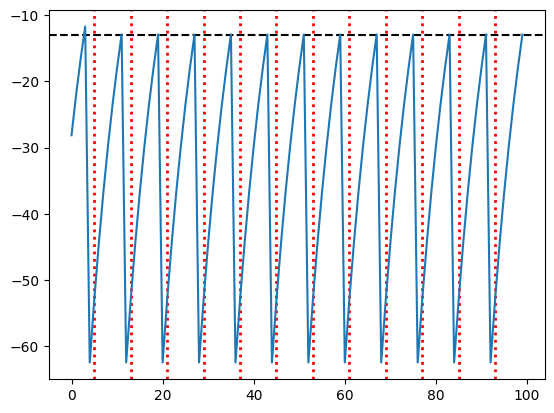

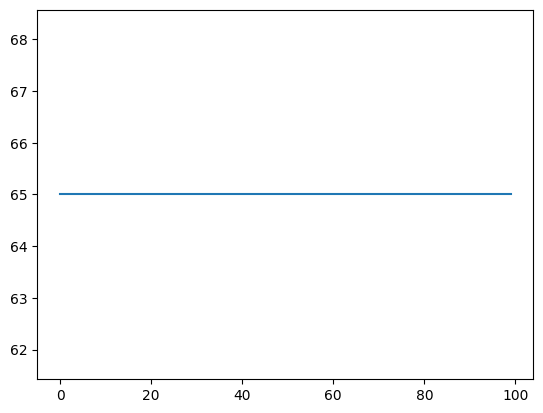

In [144]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    1,
    net=net1,
    behavior={
        2: SetCurrent(value=65),
        3: StepFunction(value=0, t0=20),
        # 4: InpSyn(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1.5,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "cnt"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_rec, ng1_evrec"),
    },
    tag="NG1",
)

# SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
#                  3: SynFun(),
#             })

net1.initialize()

net1.simulate_iterations(100)


# print(net1["ng1_rec", 0]["v", 0])
# print(net1["ng1_evrec", 0]["spike", 0])

for i, t in enumerate(net1['spike', 0]) :
    plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)

plt.axhline(-13, color = 'black', linestyle = '--')



plt.plot(net1["v", 0][:,:1])
plt.show()

plt.plot(net1["I", 0][:,:1])    
plt.show()

# plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
# plt.show()

In [145]:
net1["cnt"][0][99][0].item()/net1.iteration * net1.dt # net["tag"][tag_num][iteration][neuron]

0.12

In [146]:
class StepFunction(Behavior):
	def initialize(self, ng):
		self.value = self.parameter("value")
		self.t0 = self.parameter("t0")

	def forward(self, ng):
		if ng.network.iteration * ng.network.dt >= self.t0:
			ng.I += ng.vector(mode=self.value) * ng.network.dt

In [147]:
class NoiseFun(Behavior) :
    def initialize(self, ng):
        self.value = self.parameter("value", 10)

    def forward(self, ng):
        ng.I = (ng.vector(mode = self.value) * ng.network.dt + ((random.random() * self.value - self.value/2))) 
        

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:NoiseFun(value=40,)5:LIF(tau=25,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'cnt'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_evrec,arg_0=['spike'],)}
100xBatch: 1/1 (100%) 32.013ms
Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:NoiseFun(value=45,)5:LIF(tau=25,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'cnt'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_evrec,arg_0=['spik

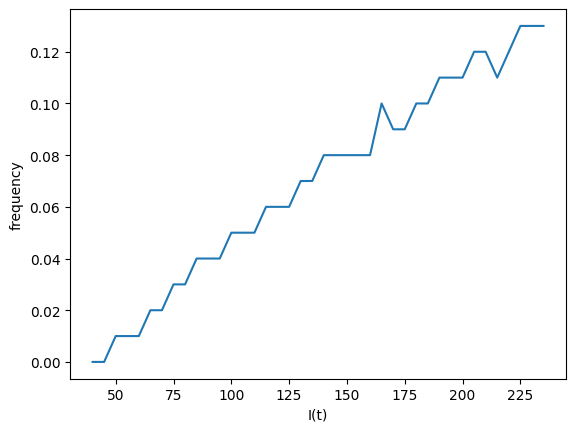

In [148]:
freqs = []
currs = []
for i in range(40, 240, 5):
    net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
    ng1 = NeuronGroup(
    1,
    net=net1,
    behavior={
        # 2: SetCurrent(value=i),
        # 3: StepFunction(value=0, t0=20),
        2 : NoiseFun(value=i),
        # 4: InpSyn(),
        5: LIF(
            tau=25,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "cnt"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_rec, ng1_evrec"),
    },
    tag="NG1",
    )


    net1.initialize()

    net1.simulate_iterations(100)

    freqs.append(net1["cnt"][0][99][0].item()/net1.iteration * net1.dt)
    currs.append(i)

plt.plot(currs, freqs)   
plt.xlabel("I(t)")
plt.ylabel("frequency") 
plt.show()


F-I on ELIF

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:NoiseFun(value=40,)5:ELIF(tau=25,u_rest=-65,u_reset=-73,threshold=-13,R=1,Delta_t=60,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'cnt'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_evrec,arg_0=['spike'],)}
100xBatch: 1/1 (100%) 65.120ms
Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:NoiseFun(value=45,)5:ELIF(tau=25,u_rest=-65,u_reset=-73,threshold=-13,R=1,Delta_t=60,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'cnt'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec

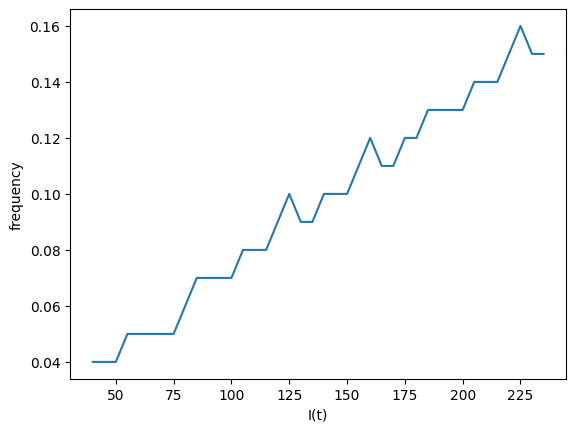

In [149]:
freqs = []
currs = []
for i in range(40, 240, 5):
    net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
    ng1 = NeuronGroup(
    1,
    net=net1,
    behavior={
        # 2: SetCurrent(value=i),
        # 3: StepFunction(value=0, t0=20),
        2 : NoiseFun(value=i),
        # 4: InpSyn(),
        5: ELIF(
            tau=25,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            Delta_t=60,
            #theta_rh=-25,
            
            v_init="normal(-40, 10)"
        ),
        9: Recorder(variables=["v", "I", "cnt"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_rec, ng1_evrec"),
    },
    tag="NG1",
    )


    net1.initialize()

    net1.simulate_iterations(100)

    freqs.append(net1["cnt"][0][99][0].item()/net1.iteration * net1.dt)
    currs.append(i)

plt.plot(currs, freqs)   
plt.xlabel("I(t)")
plt.ylabel("frequency") 
plt.show()


F-I on AELIF

In [150]:
class AELIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")

		self.Delta_t = self.parameter("Delta_t", 2)

		self.a=self.parameter("a", 5)
		self.b=self.parameter("b", 5)
		ng.w = ng.vector("zeros")
		self.tau_w = self.parameter("tau_w", 2)

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset

		ng.cnt = ng.vector("zeros") 
		


	def forward(self, ng):
		# firing
		ng.spike = ng.v >= self.threshold

		#reset
		ng.v[ng.spike] = self.u_reset

		ng.cnt[ng.spike]+=1

		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I
		expon = (self.Delta_t * torch.exp((ng.v - self.threshold)/self.Delta_t))
		adpt = (self.R * ng.w)
		ng.v += ((leakage + currents) + expon - adpt) / self.tau * ng.network.dt
		ng.w += (self.a*(ng.v - self.u_rest) - ng.w + self.b * self.tau_w * ng.spike) / self.tau_w * ng.network.dt


Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:SetCurrent(value=60,)3:StepFunction(value=0,t0=20,)5:AELIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,Delta_t=30,R=1,tau_w=40,a=2,b=0.7,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'cnt'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_evrec,arg_0=['spike'],)}
100xBatch: 1/1 (100%) 45.276ms


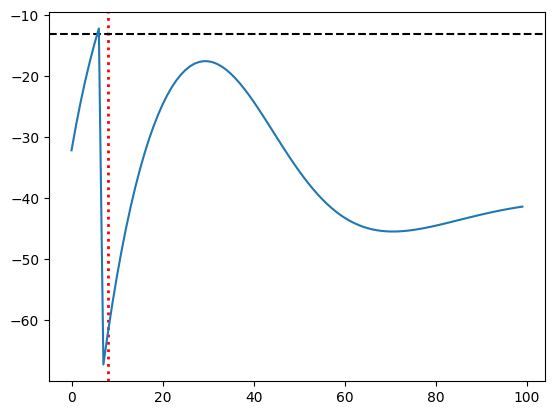

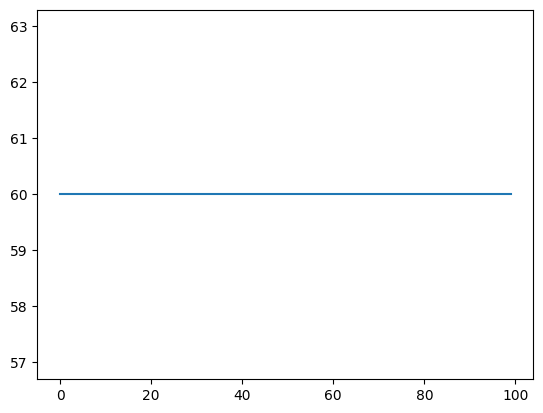

In [151]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    1,
    net=net1,
    behavior={
        2: SetCurrent(value=60),
        3: StepFunction(value=0, t0=20),
        # 4: InpSyn(),
        5: AELIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            Delta_t = 30,
            R=1,
            tau_w=40,
            a=2,
            b=.7,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "cnt"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_rec, ng1_evrec"),
    },
    tag="NG1",
)

# SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
#                  3: SynFun(),
#             })

net1.initialize()

net1.simulate_iterations(100)


# print(net1["ng1_rec", 0]["v", 0])
# print(net1["ng1_evrec", 0]["spike", 0])

for i, t in enumerate(net1['spike', 0]) :
    plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)

plt.axhline(-13, color = 'black', linestyle = '--')



plt.plot(net1["v", 0][:,:1])
plt.show()

plt.plot(net1["I", 0][:,:1])    
plt.show()

# plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
# plt.show()

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:NoiseFun(value=40,)5:AELIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,Delta_t=10,R=1,tau_w=40,a=2,b=0.7,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'cnt'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_evrec,arg_0=['spike'],)}
100xBatch: 1/1 (100%) 49.997ms
Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:NoiseFun(value=45,)5:AELIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,Delta_t=10,R=1,tau_w=40,a=2,b=0.7,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I', 'cnt'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_le

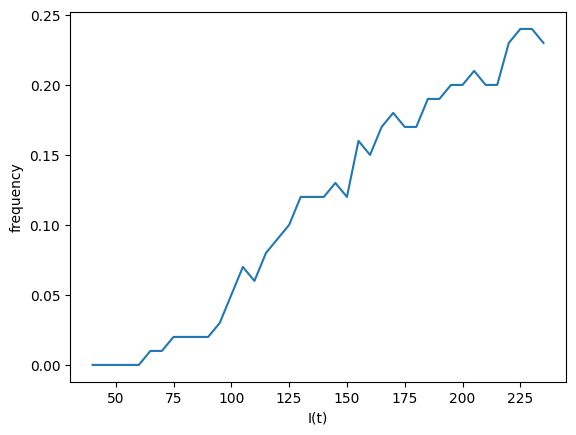

In [152]:
freqs = []
currs = []
for i in range(40, 240, 5):
    net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
    ng1 = NeuronGroup(
    1,
    net=net1,
    behavior={
        # 2: SetCurrent(value=i),
        # 3: StepFunction(value=0, t0=20),
        2 : NoiseFun(value=i),
        # 4: InpSyn(),
        5: AELIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            Delta_t = 10,
            R=1,
            tau_w=40,
            a=2,
            b=.7,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I", "cnt"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_rec, ng1_evrec"),
    },
    tag="NG1",
    )


    net1.initialize()

    net1.simulate_iterations(100)

    freqs.append(net1["cnt"][0][99][0].item()/net1.iteration * net1.dt)
    currs.append(i)

plt.plot(currs, freqs)   
plt.xlabel("I(t)")
plt.ylabel("frequency") 
plt.show()


Refractory

In [153]:
class LIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset
		
		ng.refractory_period = ng.vector("zeros")


	def forward(self, ng):
		
		# firing
		ng.spike = ng.v >= self.threshold

		ng.refractory_period[ng.spike] = 10

		#reset
		ng.v[ng.spike] = self.u_reset
		
		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I * (ng.refractory_period == 0)
		ng.v += (leakage + currents) / self.tau * ng.network.dt
		
		ng.refractory_period = max(ng.refractory_period - 1, ng.vector("zeros"))

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](1){2:SetCurrent(value=50,)3:StepFunction(value=20,t0=20,)5:LIF(tau=20,u_rest=-65,u_reset=-73,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=['spike'],)}
200xBatch: 1/1 (100%) 74.622ms


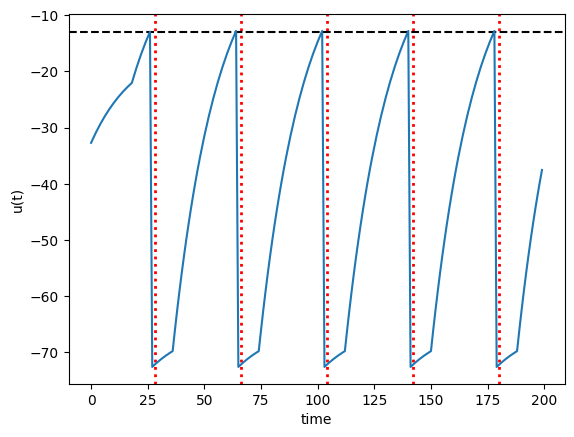

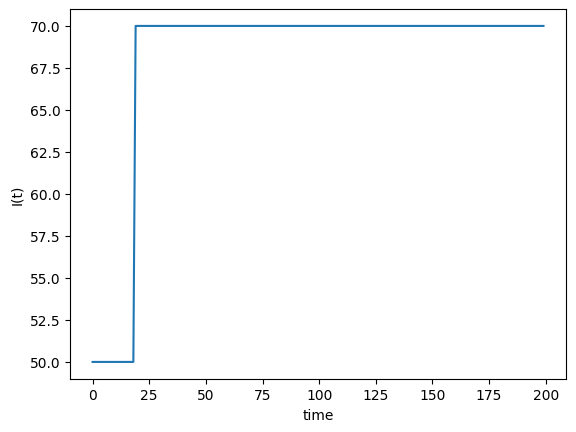

In [154]:
net1 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng1 = NeuronGroup(
    1,
    net=net1,
    behavior={
        2: SetCurrent(value=50),
        3: StepFunction(value=20, t0=20),
        # 4: InpSyn(),
        5: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
        10: EventRecorder(["spike"], tag="ng1_evrec"),
    },
    tag="NG1",
)

# SynapseGroup(net=net1, src=ng1, dst=ng1, behavior={
#                  3: SynFun(),
#             })

net1.initialize()

net1.simulate_iterations(200)

# print(net1["ng1_rec", 0]["v", 0])
# print(net1["ng1_evrec", 0]["spike", 0])

for i, t in enumerate(net1['spike', 0]) :
    plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)

plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net1["v", 0][:,:1])
plt.xlabel("time")
plt.ylabel("u(t)")
plt.show()

plt.plot(net1["I", 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()

# plt.scatter(net1["spike", 0][:,0], net1["spike", 0][:,1])
# plt.show()

ELIF with refractory period

In [155]:
class ELIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")
		self.Delta_t = self.parameter("Delta_t", 2)
		#self.theta_rh = self.parameter("theta_rh")

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset

		ng.cnt = ng.vector("zeros")

		ng.refractory_period = ng.vector("zeros")


	def forward(self, ng):
		# firing
		ng.spike = ng.v >= self.threshold

		ng.refractory_period[ng.spike] = 8

		#reset
		ng.v[ng.spike] = self.u_reset
		
		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I * (ng.refractory_period == 0)
		expon = (self.Delta_t * torch.exp((ng.v - self.threshold)/self.Delta_t))
		ng.v += (leakage + currents + expon) / self.tau * ng.network.dt

		ng.refractory_period = max(ng.refractory_period - 1, ng.vector("zeros"))


Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG3', 'NeuronGroup', 'ng'](1){2:SetCurrent(value=30,)3:StepFunction(value=20,t0=20,)5:ELIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,R=1,Delta_t=40,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng3_rec, ng3_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng3_evrec,arg_0=spike,)}
100xBatch: 1/1 (100%) 88.763ms


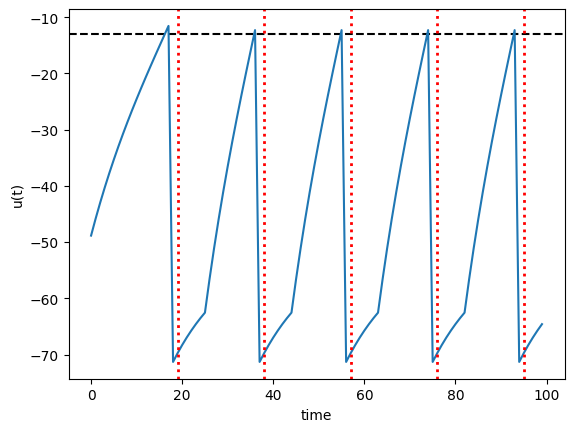

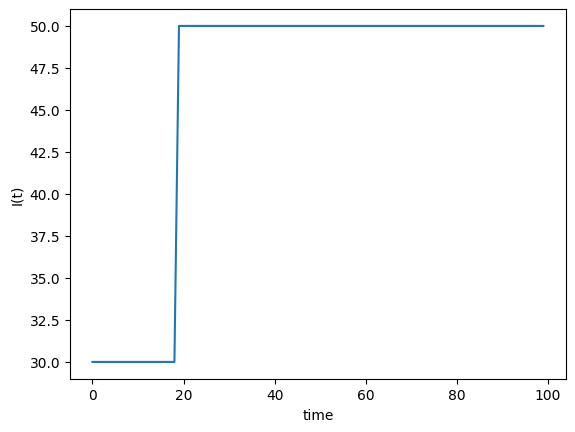

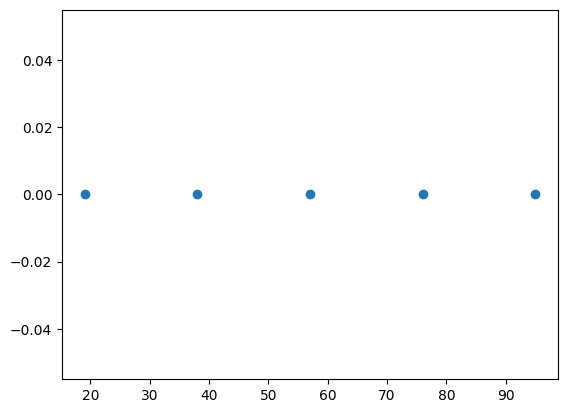

In [156]:
net3 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng3 = NeuronGroup(
    1,
    net=net3,
    behavior={
        2: SetCurrent(value=30),
        3: StepFunction(value=20, t0=20),
        # 4: InpSyn(),
        5: ELIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            R=1,
            Delta_t=40,
            #theta_rh=-25,
            
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I"], tag="ng3_rec, ng3_recorder"),
        10: EventRecorder("spike", tag="ng3_evrec"),
    },
    tag="NG3",
)

# SynapseGroup(net=net3, src=ng3, dst=ng3, behavior={
#                  3: SynFun(),
#             })

net3.initialize()

net3.simulate_iterations(100)

# print(net3["ng3_rec", 0]["v", 0])
# print(net3["ng3_evrec", 0]["spike", 0])

plt.axhline(-13, color = 'black', linestyle = '--')


plt.plot(net3["v", 0][:,:1])
for i, t in enumerate(net3['spike', 0]) :
    plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)
plt.xlabel("time")
plt.ylabel("u(t)")
plt.show()

plt.plot(net3["I", 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()

plt.scatter(net3["spike", 0][:,0], net3["spike", 0][:,1])
plt.show()

AELIF with refractory period

In [157]:
class AELIF(Behavior):
	def initialize(self, ng):
		self.tau = self.parameter("tau")
		self.u_rest = self.parameter("u_rest")
		self.u_reset = self.parameter("u_reset")
		self.threshold = self.parameter("threshold")
		self.R = self.parameter("R")

		self.Delta_t = self.parameter("Delta_t", 2)

		self.a=self.parameter("a", 5)
		self.b=self.parameter("b", 5)
		ng.w = ng.vector("zeros")
		self.tau_w = self.parameter("tau_w", 2)

		k = self.parameter("v_init", default="normal(0.3, 0.05)")

		# ng.threshold = ng.vector(mode='init_threshold')
		ng.v = ng.vector(mode=k)
		ng.spike = ng.v >= self.threshold
		ng.v[ng.spike] = self.u_reset

		ng.refractory_period = ng.vector("zeros")
		


	def forward(self, ng):
		# firing
		ng.spike = ng.v >= self.threshold

		ng.refractory_period[ng.spike] = 8

		#reset
		ng.v[ng.spike] = self.u_reset


		# dynamic
		leakage = -(ng.v - self.u_rest)
		currents = self.R * ng.I * (ng.refractory_period == 0)
		expon = (self.Delta_t * torch.exp((ng.v - self.threshold)/self.Delta_t))
		adpt = (self.R * ng.w)
		ng.v += ((leakage + currents) + expon - adpt) / self.tau * ng.network.dt
		ng.w += (self.a*(ng.v - self.u_rest) - ng.w + self.b * self.tau_w * ng.spike) / self.tau_w * ng.network.dt

		ng.refractory_period = max(ng.refractory_period - 1, ng.vector("zeros"))

Network['Network_1', 'Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(0.)|0 groups){1:TimeResolution()}
NeuronGroup['NG4', 'NeuronGroup', 'ng'](1){2:SetCurrent(value=20,)3:StepFunction(value=50,t0=20,)5:AELIF(tau=10,u_rest=-65,u_reset=-73,threshold=-13,Delta_t=30,R=1,tau_w=40,a=2,b=0.7,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng4_rec, ng4_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng4_evrec,arg_0=spike,)}
100xBatch: 1/1 (100%) 57.582ms


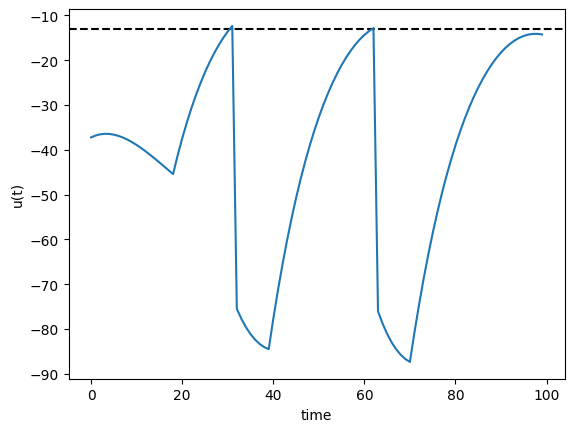

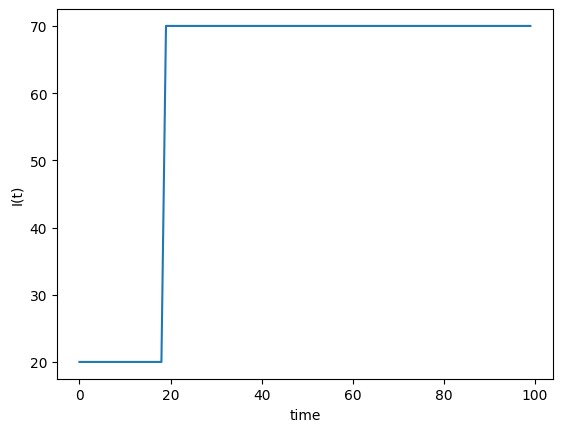

In [158]:
net4 = Network(behavior={1: TimeResolution()}, dtype=torch.float64)

ng4 = NeuronGroup(
    1,
    net=net4,
    behavior={
        2: SetCurrent(value=20),
        3: StepFunction(value=50, t0=20),
        # 4: InpSyn(),
        5: AELIF(
            tau=10,
            u_rest=-65,
            u_reset=-73,
            threshold=-13,
            Delta_t = 30,
            R=1,
            tau_w=40,
            a=2,
            b=.7,
            v_init="normal(-40, 10)",
        ),
        9: Recorder(variables=["v", "I"], tag="ng4_rec, ng4_recorder"),
        10: EventRecorder("spike", tag="ng4_evrec"),
    },
    tag="NG4",
)

# SynapseGroup(net=net4, src=ng4, dst=ng4, behavior={
#                  3: SynFun(),
#             })

net4.initialize()

net4.simulate_iterations(100)

# print(net4["ng4_rec", 0]["v", 0])
# print(net4["ng4_evrec", 0]["spike", 0])

plt.axhline(-13, color = 'black', linestyle = '--')

plt.plot(net4["v", 0][:,:1])
# for i, t in enumerate(net10['spike', 0]) :
#     plt.axvline(t[0].item(), ls=':', c = 'r', lw = 2, label = 'Spikes' if i == 0 else None)
plt.xlabel("time")
plt.ylabel("u(t)")
plt.show()

plt.plot(net4["I", 0][:,:1])
plt.xlabel("time")
plt.ylabel("I(t)")
plt.show()

# plt.scatter(net4["spike", 0][:,0], net4["spike", 0][:,1])
# plt.show()